# Classification models to detect chronic kidney disease

## PHASE 1: Data exploration and cleaning

**IMPORT LIBRARIES**

To develop this classification model we are going to use the sklearn library because it has several algorithms such as support vector machines, random forests and k-neighbors, and it also supports numerical and scientific Python libraries such as NumPy.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import itertools

**1.1 UPLOADING THE DATA**

Next, the following dataframe generated in pandas and loaded through a xlsx file called **chronickidney.xlsx** will be declared.

In [2]:
df = pd.read_excel("chronickidney.xlsx")

In [3]:
df.shape

(400, 25)

**1.2 INITIAL EXPLORATION OF THE DATA**

**Observation of information**

In [4]:
df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,class
0,48,80,1.02,1,0,?,normal,notpresent,notpresent,121,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,7,50,1.02,4,0,?,normal,notpresent,notpresent,?,...,38,6000,?,no,no,no,good,no,no,ckd
2,62,80,1.01,2,3,normal,normal,notpresent,notpresent,423,...,31,7500,?,no,yes,no,poor,no,yes,ckd
3,48,70,1.005,4,0,normal,abnormal,present,notpresent,117,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,51,80,1.01,2,0,normal,normal,notpresent,notpresent,106,...,35,7300,4.6,no,no,no,good,no,no,ckd


It is observed that the data contained in the data frame are numeric and categorical features. Null values are appreciated with the symbol **?**.

**Checking for Null Values**

After checking that the null values are identified with the symbol "**?**" they are replaced by Nans.

In [5]:
df.replace("?", np.nan, inplace = True)

In [6]:
df.isnull().sum()

age        9
bp        12
sg        47
al        46
su        49
rbc      152
pc        65
pcc        4
ba         4
bgr       44
bu        19
sc        17
sod       87
pot       88
hemo      52
pcv       71
wc       106
rc       131
htn        2
dm         2
cad        2
appet      1
pe         1
ane        1
class      0
dtype: int64

As can be seen, there are null values in all the features except for the class variable. How to treat them will be evaluated later.

**1.3 DATA CLEANING**

**Data processing**

In [7]:
# If the row has more than 40% of the data NaN (15) is removed
df.dropna(axis=0, thresh=15, inplace = True) 
df.shape

(393, 25)

In [8]:
# All columns with more than 80 NaNs are removed
df.dropna(axis=1, thresh=320, inplace = True) 
df.shape   

(393, 20)

Numerical and categorical variables are divided for the treatment of NaNs:

In [9]:
#function to get numeric variables
lista_numericas = df._get_numeric_data().columns
df_num = df[lista_numericas]
df_num.head(5)

,age,bp,sg,al,su,bgr,bu,sc,hemo
0,48.0,80.0,1.020,1.0,0.0,121.0,36.0,1.2,15.4
1,7.0,50.0,1.020,4.0,0.0,NaN,18.0,0.8,11.3
2,62.0,80.0,1.010,2.0,3.0,423.0,53.0,1.8,9.6
3,48.0,70.0,1.005,4.0,0.0,117.0,56.0,3.8,11.2
4,51.0,80.0,1.010,2.0,0.0,106.0,26.0,1.4,11.6


In [15]:
df_cat = df.drop(lista_numericas, axis=1)
df_cat.head(5)

,pc,pcc,ba,pcv,htn,dm,cad,appet,pe,ane,class
0,normal,notpresent,notpresent,44,yes,yes,no,good,no,no,ckd
1,normal,notpresent,notpresent,38,no,no,no,good,no,no,ckd
2,normal,notpresent,notpresent,31,no,yes,no,poor,no,yes,ckd
3,abnormal,present,notpresent,32,yes,no,no,poor,yes,yes,ckd
4,normal,notpresent,notpresent,35,no,no,no,good,no,no,ckd


Features have not been detected are handled manually

In [16]:
list_num = ["pcv"]
df_cat = df_cat.drop(list_num, axis=1)
df_num= pd.concat([df_num, df[list_num]], sort=False, axis=1)

In [17]:
df_cat["al"] = df_num["al"]
del df_num["al"]

**Imputation of the NaNs**

In [18]:
#imput numeric features with 3 nearest neighbors
imputer = KNNImputer(n_neighbors=3)
df_num_imp = imputer.fit_transform(df_num)
df_num = pd.DataFrame(df_num_imp, columns = df_num.columns)

In [19]:
#imput categorical features with most frecuent
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df_cat_imp = imputer.fit_transform(df_cat)
df_cat = pd.DataFrame(df_cat_imp, columns = df_cat.columns)

**Cleanliness of features**

Data reading problems are replaced.

In [20]:
df_cat = df_cat.replace(to_replace = ["\tno", '\tyes', ' yes'], value = ['no', 'yes', 'yes'])

**Dummify categorical features and join dataframes**

All categorical features are converted to numeric and are unified in df_num. This dataframe will be used for the model.

In [21]:
for i in df_cat.columns[:-2]:
    dummy_ = pd.get_dummies(df_cat[i], prefix = i)
    df_num = pd.concat([df_num, dummy_], axis=1)

**Label encoding**

The class feature is converted to numeric, where 0 is positive chronic kidney disease and 1 negative chronic disease.

In [22]:
class_labelEncoding = LabelEncoder()
clase = class_labelEncoding.fit_transform(df["class"].values)
df_cat["clase"] = clase

**1.4 FEATURE SELECTION**

Those features that provide more information are analyzed to better understand the importance of each variable.

In [23]:
# Unlabeled data
X = np.asarray(df_num)
# Data label
y = np.asarray(df_cat["clase"])

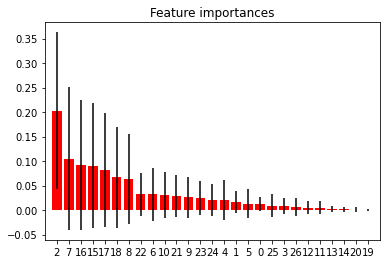

In [24]:
forest = ExtraTreesClassifier(n_estimators=250,random_state=0)
forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [25]:
#list of variables with their indexes
for j, i in enumerate(df_num.columns):
    print(j, i)

0 age
1 bp
2 sg
3 su
4 bgr
5 bu
6 sc
7 hemo
8 pcv
9 pc_abnormal
10 pc_normal
11 pcc_notpresent
12 pcc_present
13 ba_notpresent
14 ba_present
15 htn_no
16 htn_yes
17 dm_no
18 dm_yes
19 cad_no
20 cad_yes
21 appet_good
22 appet_poor
23 pe_no
24 pe_yes
25 ane_no
26 ane_yes


The features with more information are **sg**, **hemo** and **htn**. Less important features are **cad_yes** and **cad_no**.
Not dropping any variables to keep the maximum information is considered.

## PHASE 2: CLASSIFICATION  MODELS

The three models that have been selected with the best hit rate are shown below.

The validation method used is Cross-validation with 10 folders to evaluate how the results of the statistical analysis generalize to an independent data set. https://en.wikipedia.org/wiki/Cross-validation_(statistics)

In [26]:
def clasificador_x(clasificador, X):
    """Get classification model results
    
    Parameters
    ----------
    clasificador : function
         function is machine learning algorithm 
    
    X : array
        X contains unlabeled data
        
    Returns
    -------
    classification_report : str
        returns a text summary of the precision, recall, F1 score for each class.
    
    """
    
    kf = KFold(n_splits=10)
    kf.get_n_splits(X)
    yhat=[]
    lista_ies = []
    lista_exis = []
    KFold(n_splits=2, random_state=1, shuffle=True)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        yhat1 = clasificador.fit(X_train, y_train).predict(X_test)
        
        yhat.extend(yhat1)
        lista_ies.extend(y_test)
        lista_exis.extend(X_test)
    class_names = ['ckd', 'nockd']
    def plot_confusion_matrix(cm, classes,
                              normalize=False,
                              title='Confusion matrix',
                              cmap=plt.cm.Reds):
        """Get plot confusion matrix normalize or without normalize
    
        Parameters
        ----------
        cm : ndarray
             confusion matrix

        classes : lst
            class name list
            
        title : str
            confusion matrix title
            
        """
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        else:
            pass
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)
        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(yhat, lista_ies)
    np.set_printoptions(precision=2)
    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix, without normalization')
    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')
      
    
    return print(classification_report(lista_ies, yhat, digits=3))

### Logistic Regression

Logistic regression is a traditional statistical model that in its basic form uses a logistic function to model a binary dependent variable and can be used for classification problems with two possible values. https://en.wikipedia.org/wiki/Logistic_regression

              precision    recall  f1-score   support

           0      0.983     0.955     0.969       243
           1      0.930     0.973     0.951       150

    accuracy                          0.962       393
   macro avg      0.956     0.964     0.960       393
weighted avg      0.963     0.962     0.962       393



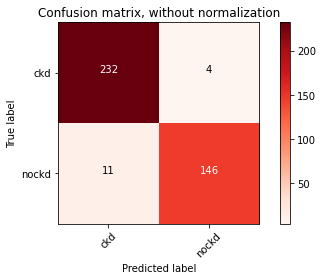

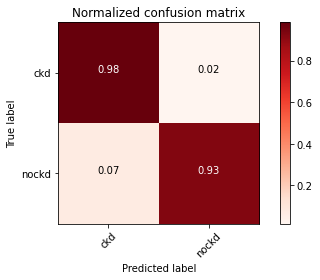

In [27]:
clasificador_x(LogisticRegression(max_iter = 1000), X)

Logistic Regression models gets an accuracy/f1-score of 0.962, and an score similiar in both classes.

### Random Forest

Random Forest are a modern and popular method for various machine learning tasks based in Decision trees. https://en.wikipedia.org/wiki/Random_forest

              precision    recall  f1-score   support

           0      0.976     0.996     0.986       243
           1      0.993     0.960     0.976       150

    accuracy                          0.982       393
   macro avg      0.984     0.978     0.981       393
weighted avg      0.982     0.982     0.982       393



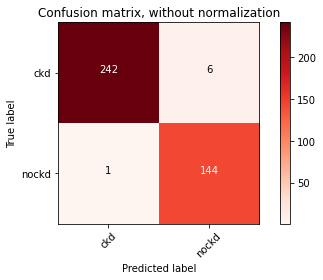

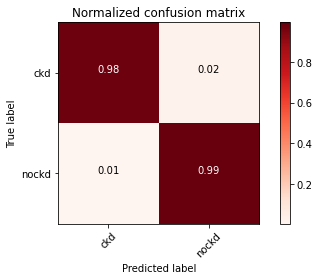

In [28]:
clasificador_x(RandomForestClassifier(), X)

Random Forest models accuracy/f1score is 0.982. This is a pretty good score but the number of false negatives is worse

### Support Vector Machines (SVM)

Support Vector Machines are a modern supervised learning models, based in machine learning used for classification and regression analysis and is one of the most robust prediction methods. https://en.wikipedia.org/wiki/Support_vector_machine

Support Vector Machines improve with scaled data. The main advantage of scaling is to avoid attributes in greater numeric ranges dominating those in smaller numeric ranges. Another advantage is to avoid numerical difficulties during the calculation.

              precision    recall  f1-score   support

           0      0.996     0.979     0.988       243
           1      0.968     0.993     0.980       150

    accuracy                          0.985       393
   macro avg      0.982     0.986     0.984       393
weighted avg      0.985     0.985     0.985       393



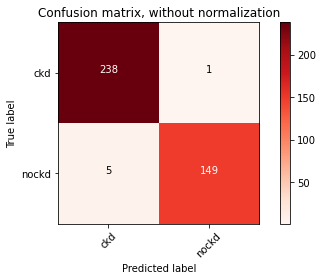

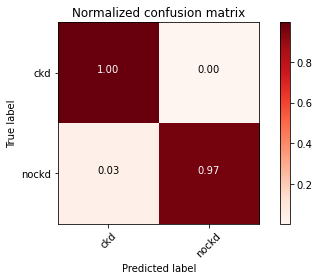

In [29]:
# Scaling center to the mean and the components to the variance of the unit
X_scaled = preprocessing.scale(X) 

clasificador_x(svm.SVC(kernel='linear'), X_scaled)

Support Vector Machines gets the best accuracy/f1-score with 0.985 points and improves the prediction of false negatives.
It is observed that when the model predicts chronic kidney disease negative the error is 0%, so the precision of the model is very acceptable. When the model predicts chronic kidney disease positive the error is 3%.

## PHASE 3: CONCLUSIONS

It is concluded that the best classifier is the Support Vector Machines (SVM) with accuracy of 98,5%.

Also, It can be concluded that the model satisfactorily predicts true negatives, with a rate of 0% of false negatives.

To improve the model, it would be necessary to have more information about the variables that are being studied and analyze the false positives to obtain possible new variables and to enrich the model.